## Process ERA5 file Tutorial

This tutorial will walk through processing forecast data from ERA5 using xarray.

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, January 2020

In [1]:
# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf

/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Find the absolute file path to your pvlib installation
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))

# absolute path to ERA data file
era_file1 = os.path.join(optwrf_abspath, 'data', 'EastUS_e5.oper.an.sfc.228_246_100u.ll025sc.2011010100_2011013123.nc')
era_file2 = os.path.join(optwrf_abspath, 'data', 'EastUS_e5.oper.an.sfc.228_247_100v.ll025sc.2011010100_2011013123.nc')

# Read in the ERA file using the xarray open_dataset method
era_data1 = xr.open_dataset(era_file1)
era_data2 = xr.open_dataset(era_file2)

In [3]:
era_data = xr.merge([era_data1, era_data2])
era_data

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 744)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-01-31T23:00:00
Data variables:
    VAR_100U   (time, latitude, longitude) float32 ...
    utc_date   (time) int32 2011010100 2011010101 ... 2011013122 2011013123
    VAR_100V   (time, latitude, longitude) float32 ...

In [4]:
# Calculate the 100m wind speed
wind_speed100 = np.sqrt(era_data['VAR_100U']**2 + era_data['VAR_100V']**2)

# Calculate wind power density (W * m -2)
air_density = 1000 
wpd = 0.5 * air_density * (wind_speed100) ** 3
era_data['wpd'] = wpd
era_data

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 744)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-01-31T23:00:00
Data variables:
    VAR_100U   (time, latitude, longitude) float32 -5.118103 ... -3.841217
    utc_date   (time) int32 2011010100 2011010101 ... 2011013122 2011013123
    VAR_100V   (time, latitude, longitude) float32 -7.5160675 ... -1.6359863
    wpd        (time, latitude, longitude) float32 375941.2 ... 36388.855

In [11]:
# # Download the ERA file containing surface solar radiation downward (ssrd)
# filelist = ['e5.oper.fc.sfc.accumu/201101/e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc']
# dspath = 'http://rda.ucar.edu/data/ds633.0/'
# runwrf.rda_download(filelist, dspath)

In [12]:
# # Use NCO tools to extract the Northeast region (only works if NCO is installed)
# CMD_REDUCE = 'ncks -d longitude,265.,295. -d latitude,30.,50. e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc'
# os.system(CMD_REDUCE)

In [13]:
# Read in the ERA file using the xarray open_dataset method
era_file3 = 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc'
era_data3 = xr.open_dataset(era_file3)
era_data3

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, forecast_initial_time: 30, latitude: 81, longitude: 121)
Coordinates:
  * forecast_hour          (forecast_hour) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-15T18:00:00
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
Data variables:
    SSRD                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 ...
    utc_date               (forecast_initial_time) int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [14]:
# Initialize a new dataset
era_proc = era_data3.drop_dims(['forecast_initial_time', 'forecast_hour'])
era_proc

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
Data variables:
    *empty*
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [15]:
# Extract SSRD from a single forecast
timestr = era_data3.forecast_initial_time[0]
ssrd_slice = era_data3.sel(forecast_initial_time=timestr)
ssrd_slice

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, latitude: 81, longitude: 121)
Coordinates:
  * forecast_hour          (forecast_hour) int32 1 2 3 4 5 6 7 8 9 10 11 12
    forecast_initial_time  datetime64[ns] 2011-01-01T06:00:00
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
Data variables:
    SSRD                   (forecast_hour, latitude, longitude) float32 ...
    utc_date               int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [19]:
# Make the forecast_hour coordinate type=datetime64
ssrd_slice = ssrd_slice.assign_coords(forecast_hour=pd.date_range(start=timestr.values, freq='H', 
                                            periods=(len(era_data3.forecast_hour))))
ssrd_slice

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, latitude: 81, longitude: 121)
Coordinates:
  * forecast_hour          (forecast_hour) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-01T17:00:00
    forecast_initial_time  datetime64[ns] 2011-01-01T06:00:00
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
Data variables:
    SSRD                   (forecast_hour, latitude, longitude) float32 ...
    utc_date               int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [20]:
# Rename the forecast_hour dimension
ssrd_slice = ssrd_slice.rename({'forecast_hour' : 'time'})
ssrd_slice

In [22]:
# Drop the forecast_initial_time coordinate
ssrd_slice = ssrd_slice.reset_coords('forecast_initial_time', drop=True)

In [23]:
ssrd_slice

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-01T17:00:00
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
Data variables:
    SSRD       (time, latitude, longitude) float32 ...
    utc_date   int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [24]:
# Add the ssrd_slice back into the era_proc dataset
era_proc['SSRD'] = ssrd_slice['SSRD']
era_proc

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 12)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-01T17:00:00
Data variables:
    SSRD       (time, latitude, longitude) float32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

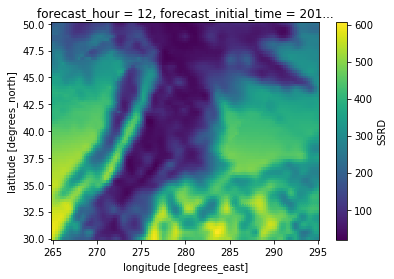

In [25]:
# Test visualization plot from initial dataset
ssrd = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 06:00:00',forecast_hour=12)
ghi = ssrd/3600
ghi.plot()

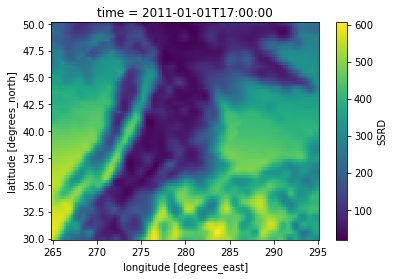

In [27]:
# Test visualization plot from processed dataset (should be the same as above)
tidx = 17
timestr = f'2011-01-01 {tidx}:00:00'
ssrd = era_proc.SSRD.sel(time=timestr)
ghi = ssrd/3600
ghi.plot()

# initial_time = era_data3['forecast_initial_time']
# ssrd1 = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 06:00:00')
# ssrd2 = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 18:00:00')
# ssrd = xr.concat([ssrd1, ssrd2], 'forecast_initial_time')
# ssrd



In [ ]:
# Now actually process the whole dataset